Practical Work in AI - Concept Models
Tragler Thomas
====================


In [1]:
from importlib import reload
import pandas as pd
import os
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import derm7pt_data
from derm7pt_data import Derm7pt_data


reload(derm7pt_data)

path = os.path.normpath('Data\\Derm7pt')

derm7pt = Derm7pt_data(path)
metadata = derm7pt.metadata
#print("#images:", len(data.images))
#print("#metadata:", len(data.metadata), "\n", data.metadata.columns)
print(metadata.shape, len(derm7pt.images))
#print(derm7pt.images.keys())

(1011, 19) 2013


In [2]:
#Data loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
my_dataset = metadata

#split data into training, validation and test sets
train_size = int(0.8 * len(my_dataset))
val_size = int(0.15 * len(my_dataset))
test_size = len(my_dataset) - train_size - val_size
#ToDo stratified sampling
#overall weird spliting ToDo
train_split, val_split, test_split = random_split(my_dataset, [train_size, val_size, test_size])

train_data, train_concepts, train_label = derm7pt.data_split_by_index(train_split.indices)
val_data, val_concepts, val_label = derm7pt.data_split_by_index(val_split.indices)
test_data, test_concepts, test_label = derm7pt.data_split_by_index(test_split.indices)

#Dataload
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)


device:  cuda
87
267
842
507
63
188
902
690
239
505
967
274
35
573
685
925
105
311
176
295
550
519
687
619
100
547
874
272
671
894
221
735
255
205
691
849
855
1003
613
880
123
888
808
390
58
648
559
417
163
423
94
762
728
1
34
903
561
498
721
738
741
670
871
760
901
474
500
952
67
642
692
275
923
263
988
968
710
667
29
984
750
804
226
833
727
922
99
624
214
781
702
340
866
345
626
160
219
232
994
59
911
513
534
533
904
323
74
684
463
213
466
756
563
583
657
555
145
528
438
477
196
974
293
73
115
366
215
822
216
935
729
25
278
890
958
970
77
467
451
198
266
525
49
789
821
185
359
532
167
385
348
53
840
539
85
969
177
258
146
288
234
347
765
551
428
363
187
281
905
934
261
983
82
72
331
199
517
384
338
1001
231
151
566
553
373
755
236
162
271
962
412
7
330
406
917
337
824
124
716
332
709
45
183
948
681
954
600
782
562
944
504
33
722
794
976
630
586
92
832
651
993
815
780
336
464
641
646
361
391
101
307
107
827
256
456
739
193
478
414
682
545
655
868
24
694
882
56
207
230
1008
299
949
775

In [3]:
my_dataset.columns

Index(['case_num', 'diagnosis', 'seven_point_score', 'pigment_network',
       'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules',
       'blue_whitish_veil', 'vascular_structures',
       'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex',
       'clinic', 'derm', 'nums', 'abbrevs', 'info'],
      dtype='object')

case_num                                                   1
diagnosis                               basal cell carcinoma
seven_point_score                                          0
pigment_network                                       absent
streaks                                               absent
pigmentation                                          absent
regression_structures                                 absent
dots_and_globules                                     absent
blue_whitish_veil                                     absent
vascular_structures                               arborizing
level_of_diagnostic_difficulty                        medium
elevation                                            nodular
location                                             abdomen
sex                                                   female
clinic                                        NEL/NEL025.JPG
derm                                          NEL/Nel026.jpg
nums                    

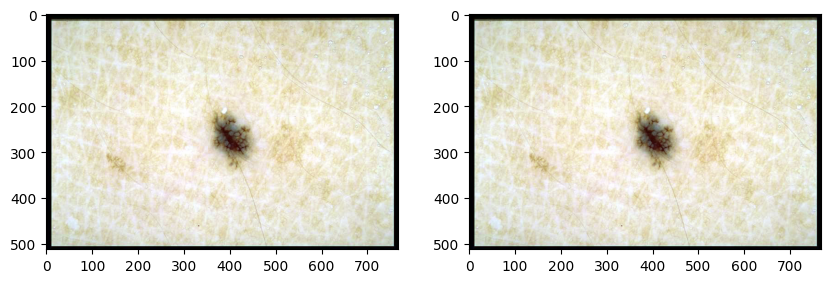

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x512 at 0x22D58098950>


In [4]:
#Display one test case

train_data.iloc[0]
#plot pil image

print(derm7pt.metadata.iloc[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_data.iloc[0, 0])
plt.subplot(1, 2, 2)
#Needed second picture for correct display
plt.imshow(train_data.iloc[0, 0])

#from PIL import Image
#plt.imshow(Image.open(os.path.join(os.getcwd(), "Data\\Derm7pt\\images", os.path.normpath(derm7pt.metadata.iloc[496].derm))))

plt.show()
print(train_data.iloc[0, 0])

In [5]:
#Torch CNN model with 3 Conv layers and 3 fully connected layers
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #conv Layers
        in_channels, out_channels = (3, 16)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        in_channels, out_channels = (out_channels, 2*out_channels)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        in_channels, out_channels = (out_channels, 2*out_channels)
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        
        #Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 192 * 128, 128)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer with one neuron for binary classification

    def forward(self, x):
        # Convolutional layers with activation and pooling
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        
        #Pooling layer
        x = self.pool(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 192 * 128)  # Corrected input size based on spatial dimensions

        # Fully connected layers with activation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

In [7]:
#Training the model
import torch.optim as optim

# Instantiate the model
model = Net()
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

KeyError: 0